# Infrastructure

In this section, we are importing necessary libraries, setting up global parameters like folders, and creating the lists of titles, years, etc. 

In [1]:
# General
import re
import pandas as pd
import word_count_func

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

In [2]:
# this is the folder that should be used: 
txt_adjusted_folder = './data/original/txts_adjusted/'
# only used in pdf extraction
txt_folder = './data/original/txts/'

In [3]:
df = pd.read_csv('./data/original/table_of_contents.csv', header = None, \
                 names = ['original_title', 'page_num','filename','year'])

# skipping first one
filenames =  df['filename'][1:]

In [4]:
# sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [5]:
# Tokenisation & TF-IDF
import spacy
nlp = spacy.load("en_core_web_lg")

In [109]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans

# Preparation

Contains code that cleans the data further. As of now: handling weird characters, most importantly quotation marks and apostrophes, which hurt lemmatization. To keep things simple, we are changing everything to ' and ". (Called typewriter apostrophe I think.)

## Example

Checking one writing for examples. 

In [57]:
my_file = open(txt_folder + 'the_dunwich_horror.txt')
raw_text = my_file.read()
characters = raw_text.lower().replace('\n','')
characters = characters.replace('\x0c','')
characters = characters.replace(' ','')

In [70]:
unique_characters = set(characters)
unique_characters_in_string = ''.join(set(characters))
unique_characters_in_string

'-2wdj0i”m8uüosczävèr‖l)q,4b76e’n—a1(:é.ftpk?x‘hg!;93―y5'

We create a string of regular characters, ones that we expect in a text. (Might be expanded later.)

In [81]:
regular_characters = 'abcdefghijklmnopqrstuvwxyz1234567890.,?!()-:;\'"'

In [82]:
for character in regular_characters:
    try:
        unique_characters.remove(character)
    except:
        pass

See what we are left with. 

In [83]:
unique_characters

{'ä', 'è', 'é', 'ü', '—', '―', '‖', '‘', '’', '”'}

In [80]:
'—' == '―'

False

In [84]:
'‘' == '’'

False

In [85]:
'‘' == "'" or  '’' == "'"

False

In [59]:
raw_text.index('ä')

36016

In [86]:
raw_text.index('è')

32285

In [88]:
raw_text.index('é')

66610

In [90]:
raw_text.index('ü')

66781

I checked in the text, the Latin letters look OK. Dashes and apostrophes are annoying. 

## Listing Characters

Let's gather a similar string, just for all the writings combined.

In [94]:
raw_text = ''
for filename in filenames:
    my_file = open(txt_folder + filename + '.txt')
    raw_text += my_file.read()
# this runs surprisingly fast

In [225]:
regular_characters = 'abcdefghijklmnopqrstuvwxyz1234567890°×·/.,?¿!¡()[]-–:;\'"áääæéêëèïñöü#&'
# expanded after considering examples in the text 

In [206]:
characters = raw_text.lower().replace('\n','')
characters = characters.replace('\x0c','')
characters = characters.replace(' ','')

In [207]:
unique_characters = set(characters)
for character in regular_characters:
    try:
        unique_characters.remove(character)
    except:
        pass

In [208]:
unique_characters

{'*', 'å', 'ν', 'ο', 'π', 'ς', 'υ', '—', '―', '‖', '‗', '‘', '’', '”', '•'}

One by one, check examples in the text make the decision whether we 1) delete, 2) leave unchanged, or 3) replace with an other character. Decision is collected in the dictionary at the end. 

In [197]:
position_1 = raw_text.find('*')
raw_text[position_1-20:position_1+20]

'ing to its ashes. \n\n*      *      * \n\nTh'

In [198]:
position_2 = raw_text[position_1 + 20:].find('*')
raw_text[position_1 + 20:][position_2-20:position_2+20]

''

In [226]:
# these letters are assumed OK
"""
 'å',
 'ν',
 'ο',
 'π',
 'ς',
 'υ',
"""

"\n 'å',\n 'ν',\n 'ο',\n 'π',\n 'ς',\n 'υ',\n"

In [195]:
position_1 = raw_text.find('ä')
raw_text[position_1-20:position_1+20]

'man authority, ―es lässt sich nicht lese'

In [196]:
position_2 = raw_text[position_1 + 20:].find('ä')
raw_text[position_1 + 20:][position_2-20:position_2+20]

'ces of the Widmannstätten \nfigures found'

In [200]:
character_to_check = '–'
position_1 = raw_text.find(character_to_check)
raw_text[position_1-20:position_1+20]

' \nthe winter of 1900–1901, when to the s'

In [201]:
position_2 = raw_text[position_1 + 20:].find(character_to_check)
raw_text[position_1 + 20:][position_2-20:position_2+20]

' of September 24, 19––, I heard a knock '

In [212]:
character_to_check = '—'
position_1 = raw_text.find(character_to_check)
raw_text[position_1-20:position_1+20]

'ams of a waning moon—but of these things'

In [213]:
position_2 = raw_text[position_1 + 20:].find(character_to_check)
raw_text[position_1 + 20:][position_2-20:position_2+20]

'Than white as a lily—and dead half a yea'

In [214]:
character_to_check = '―'
position_1 = raw_text.find(character_to_check)
raw_text[position_1-20:position_1+20]

'g to what they call ―divine wrath‖ in a '

In [215]:
position_2 = raw_text[position_1 + 20:].find(character_to_check)
raw_text[position_1 + 20:][position_2-20:position_2+20]

'd bore the initials ―J. H.‖ The face was'

In [216]:
character_to_check = '‖'
position_1 = raw_text.find(character_to_check)
raw_text[position_1-20:position_1+20]

'y call ―divine wrath‖ in a \nmanner that '

In [217]:
position_2 = raw_text[position_1 + 20:].find(character_to_check)
raw_text[position_1 + 20:][position_2-20:position_2+20]

' the initials ―J. H.‖ The face was such '

In [218]:
character_to_check = '‗'
position_1 = raw_text.find(character_to_check)
raw_text[position_1-20:position_1+20]

'ation to reach some ‗big, big \ncabin wit'

In [219]:
position_2 = raw_text[position_1 + 20:].find(character_to_check)
raw_text[position_1 + 20:][position_2-20:position_2+20]

' and kill a certain ‗thing that shines a'

In [223]:
character_to_check = '•'
position_1 = raw_text.find(character_to_check)
raw_text[position_1-20:position_1+20]

'an decadence: \n\nHEL • HELOYM • SOTHER • '

In [224]:
#that looks intentional, leave it

In [241]:
replace_dict = {}
replace_dict['*'] = ''
replace_dict['—'] = '–'
replace_dict['―'] = ''
replace_dict['‖'] = '\"'
replace_dict['‗'] = ''
replace_dict['”'] = '"'
replace_dict['‘'] = '\''
replace_dict['’'] = '\''

## Adjusting the Text Files

Loop through the writings, replace the text, then save in the adjusted txt folder. 

In [248]:
for filename in filenames: 
    # read in original file
    my_file = open(txt_folder + filename + '.txt')
    raw_text = my_file.read()
    # replace characters
    for replace_char in replace_dict: 
        raw_text = raw_text.replace(replace_char, replace_dict[replace_char])
    # save the adjusted text in a different file
    text_file = open(txt_adjusted_folder + filename + '.txt', 'w')
    text_file.write(raw_text)
    text_file.close()

# Word Count

Simply count the words, can use string split for that. 
This will for example combine end-of-sentence punctuations, but that's fine. 

In [5]:
my_file = open(txt_folder + 'the_dunwich_horror.txt')
raw_text = my_file.read()

In [6]:
words = raw_text.split()

In [7]:
len(words)

17435

this would not work, leaves in dashes, like 'superstition—but'

In [8]:
words = re.split(r'[-\s.,;—!‖?]+', raw_text)

In [9]:
len(words)

17607

# Tokenisation and Word Analysis with NLTK

In [18]:
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TreebankWordTokenizer

## Tokenisation

Instead of analysing a whole story, start with a paragraph, see how we split it. Text_1 is easy, general English, Text_2 is difficult. 

In [15]:
text_1 = "He did not respond, and still the viol shrieked on without slackening. I moved my hand to his head, whose mechanical nodding I was able to stop, and shouted in his ear that we must both flee from the unknown things of the night. But he neither answered me nor abated the frenzy of his unutterable music, while all through the garret strange currents of wind seemed to dance in the darkness and babel. When my hand touched his ear I shuddered, though I knew not why—knew not why till I felt of the still face; the ice-cold, stiffened, unbreathing face whose glassy eyes bulged uselessly into the void. And then, by some miracle finding the door and the large wooden bolt, I plunged wildly away from that glassy-eyed thing in the dark, and from the ghoulish howling of that accursed viol whose fury increased even as I plunged."

text_2 = \
"""
Boss," cried Schultz, as he entered the vile-smelling room with his young victim, meet my 
friend Al Trever, bes' li'l' sport up at Lawrence–thas' 'n Appleton, Wis., y' know. Some swell 
guy, too–'s father's a big corp'ration lawyer up in his burg, 'n' 's mother's some lit'ry genius. 
He wants to see life as she is–wants to know what the real lightnin' juice tastes like–so jus' 
remember he's me friend an' treat 'im right." 
"""

### Simple Text

In [20]:
string_tokenizer_1 = '[a-zA-Z0-9]+'
string_tokenizer_2 = r'\w+|$[0-9.]+|\S+'

In [32]:
tokenizer = RegexpTokenizer(string_tokenizer_1)
tokens = tokenizer.tokenize(text_1)
print(len(tokens))
tokens[:20]

152


['He',
 'did',
 'not',
 'respond',
 'and',
 'still',
 'the',
 'viol',
 'shrieked',
 'on',
 'without',
 'slackening',
 'I',
 'moved',
 'my',
 'hand',
 'to',
 'his',
 'head',
 'whose']

In [34]:
tokenizer = RegexpTokenizer(string_tokenizer_2)
tokens = tokenizer.tokenize(text_1)
print(len(tokens))
tokens[:20]

167


['He',
 'did',
 'not',
 'respond',
 ',',
 'and',
 'still',
 'the',
 'viol',
 'shrieked',
 'on',
 'without',
 'slackening',
 '.',
 'I',
 'moved',
 'my',
 'hand',
 'to',
 'his']

source: http://www.nltk.org/book/ch01.html
https://www.nltk.org/book/ch03.html

In [35]:
tokenizer = TreebankWordTokenizer()
tokens = tokenizer.tokenize(text_1)
print(len(tokens))
tokens[:20]

161


['He',
 'did',
 'not',
 'respond',
 ',',
 'and',
 'still',
 'the',
 'viol',
 'shrieked',
 'on',
 'without',
 'slackening.',
 'I',
 'moved',
 'my',
 'hand',
 'to',
 'his',
 'head']

I think the Regexp performed better with a simple text, but only because we did not split the sentences. 

### Apostrophe Test

In [ ]:
tokenizer = TreebankWordTokenizer()

In [27]:
test_sentence_2 = "Why wouldn't we?"
tokenizer.tokenize(test_sentence_2)

In [29]:
test_sentence_3 = "Why wouldn‘t we?"
tokenizer.tokenize(test_sentence_3)

### Difficult Text

In [39]:
tokenizer = RegexpTokenizer(string_tokenizer_2)
tokens = tokenizer.tokenize(text_2)
print(len(tokens))
tokens

101


['Boss',
 ',"',
 'cried',
 'Schultz',
 ',',
 'as',
 'he',
 'entered',
 'the',
 'vile',
 '-smelling',
 'room',
 'with',
 'his',
 'young',
 'victim',
 ',',
 'meet',
 'my',
 'friend',
 'Al',
 'Trever',
 ',',
 'bes',
 "'",
 'li',
 "'l'",
 'sport',
 'up',
 'at',
 'Lawrence',
 "–thas'",
 "'n",
 'Appleton',
 ',',
 'Wis',
 '.,',
 'y',
 "'",
 'know',
 '.',
 'Some',
 'swell',
 'guy',
 ',',
 'too',
 "–'s",
 'father',
 "'s",
 'a',
 'big',
 'corp',
 "'ration",
 'lawyer',
 'up',
 'in',
 'his',
 'burg',
 ',',
 "'n'",
 "'s",
 'mother',
 "'s",
 'some',
 'lit',
 "'ry",
 'genius',
 '.',
 'He',
 'wants',
 'to',
 'see',
 'life',
 'as',
 'she',
 'is',
 '–wants',
 'to',
 'know',
 'what',
 'the',
 'real',
 'lightnin',
 "'",
 'juice',
 'tastes',
 'like',
 '–so',
 'jus',
 "'",
 'remember',
 'he',
 "'s",
 'me',
 'friend',
 'an',
 "'",
 'treat',
 "'im",
 'right',
 '."']

In [40]:
tokenizer = TreebankWordTokenizer()
tokens = tokenizer.tokenize(text_2)
print(len(tokens))
tokens

101


['Boss',
 ',',
 "''",
 'cried',
 'Schultz',
 ',',
 'as',
 'he',
 'entered',
 'the',
 'vile-smelling',
 'room',
 'with',
 'his',
 'young',
 'victim',
 ',',
 'meet',
 'my',
 'friend',
 'Al',
 'Trever',
 ',',
 'bes',
 "'",
 'li',
 "'",
 'l',
 "'",
 'sport',
 'up',
 'at',
 'Lawrence–thas',
 "'",
 "'",
 'n',
 'Appleton',
 ',',
 'Wis.',
 ',',
 'y',
 "'",
 'know.',
 'Some',
 'swell',
 'guy',
 ',',
 'too–',
 "'s",
 'father',
 "'s",
 'a',
 'big',
 "corp'ration",
 'lawyer',
 'up',
 'in',
 'his',
 'burg',
 ',',
 "'",
 'n',
 "'",
 "'s",
 'mother',
 "'s",
 'some',
 "lit'ry",
 'genius.',
 'He',
 'wants',
 'to',
 'see',
 'life',
 'as',
 'she',
 'is–wants',
 'to',
 'know',
 'what',
 'the',
 'real',
 'lightnin',
 "'",
 'juice',
 'tastes',
 'like–so',
 'jus',
 "'",
 'remember',
 'he',
 "'s",
 'me',
 'friend',
 'an',
 "'",
 'treat',
 "'im",
 'right',
 '.',
 "''"]

## N-Grams

In [5]:
from nltk.util import ngrams

In [17]:
two_grams = list(ngrams(tokens,2))

In [21]:
my_dict = {x:two_grams.count(x) for x in two_grams}

In [22]:
sorted_d = sorted(my_dict.items(), key=lambda x: x[1])

In [24]:
sorted_d[-20:]

[(('o', '‘'), 26),
 (('of', 'a'), 29),
 (('It', 'was'), 30),
 ((',', 'the'), 31),
 (('seemed', 'to'), 31),
 ((';', 'and'), 33),
 (('at', 'the'), 38),
 ((',', 'an'), 42),
 (('from', 'the'), 46),
 (('‘', 't'), 46),
 ((',', 'but'), 54),
 (('on', 'the'), 58),
 (('to', 'the'), 59),
 (('and', 'the'), 64),
 (('.', '.'), 78),
 (('an', '‘'), 80),
 (('in', 'the'), 85),
 (('‘', 's'), 135),
 (('of', 'the'), 170),
 ((',', 'and'), 233)]

trying out things from nltk guide, need to convert to nltk text, based on forum here: https://stackoverflow.com/questions/29110950/python-concordance-command-in-nltk

## Other NLTK Stuff

ply with concordance and similar

In [28]:
textList = Text(tokens)
textList.concordance('horror')

Displaying 24 of 24 matches:
The Dunwich Horror ―Gorgons , and Hydras , and Chimaer
ble , and since a certain season of horror all the signboards pointing toward 
 our sensible age—since the Dunwich horror of 1928 was hushed up by those who 
ave the facts concerning the recent horror , can say just what is the matter w
ded only in 1928 , when the Dunwich horror came and went ; yet at no time did 
 was thought very notable until the horror of 1928 suggested the most valid of
some terrible part of the intruding horror , and to glimpse a hellish advance 
tains that May-Night ? What Roodmas horror fastened itself on the world in hal
as Wilbur Whateley. VI. The Dunwich horror itself came between Lammas and the 
 the dark of September 9th that the horror broke loose. The hill noises had be
and Cold Spring Glen , examining in horror the vast , monstrous prints , the m
end and beard the unknown Cyclopean horror in its lair. Three dogs that were w
re were many who hoped that the new horror had 

In [32]:
textList.similar('unseen')

dunwich new recent serene intruding mountainous


# SpaCy

https://spacy.io/usage/linguistic-features#tokenization

## Basic Tokenisation

In [11]:
text_1 = 'I moved my hand to his head, whose mechanical nodding I was able to stop, and shouted in his ear that we must both flee from the unknown things of the night.'

text_3 = \
"""
He did not respond, and still the viol shrieked on without slackening. I moved my hand to his head, whose mechanical nodding I was able to stop, and shouted in his ear that we must both flee from the unknown things of the night. But he neither answered me nor abated the frenzy of his unutterable music, while all through the garret strange currents of wind seemed to dance in the darkness and babel. When my hand touched his ear I shuddered, though I knew not why—knew not why till I felt of the still face; the ice-cold, stiffened, unbreathing face whose glassy eyes bulged uselessly into the void. And then, by some miracle finding the door and the large wooden bolt, I plunged wildly away from that glassy-eyed thing in the dark, and from the ghoulish howling of that accursed viol whose fury increased even as I plunged.
"""

text_2 = \
"""
Boss," cried Schultz, as he entered the vile-smelling room with his young victim, meet my 
friend Al Trever, bes' li'l' sport up at Lawrence–thas' 'n Appleton, Wis., y' know. Some swell 
guy, too–'s father's a big corp'ration lawyer up in his burg, 'n' 's mother's some lit'ry genius. 
He wants to see life as she is–wants to know what the real lightnin' juice tastes like–so jus' 
remember he's me friend an' treat 'im right." 
"""

In [1]:
import spacy
from spacy import displacy

In [2]:
nlp = spacy.load("en_core_web_sm")
nlp2 = spacy.load('en_core_web_lg')

In [17]:
doc = nlp(text_1)

for token in doc:
    print(token.text, token.lemma_, token.is_stop)

I -PRON- True
moved move False
my -PRON- True
hand hand False
to to True
his -PRON- True
head head False
, , False
whose whose True
mechanical mechanical False
nodding nodding False
I -PRON- True
was be True
able able False
to to True
stop stop False
, , False
and and True
shouted shout False
in in True
his -PRON- True
ear ear False
that that True
we -PRON- True
must must True
both both True
flee flee False
from from True
the the True
unknown unknown False
things thing False
of of True
the the True
night night False
. . False


In [10]:
doc = nlp(
"""
Some swell guy, too–'s father's a big corp'ration lawyer up in his burg, 'n' 's mother's some lit'ry genius.
""")
for token in doc:
    print(token.text, token.lemma_, token.pos_)


 
 SPACE
Some some DET
swell swell ADJ
guy guy NOUN
, , PUNCT
too too ADV
– – PUNCT
's 's PART
father father NOUN
's be AUX
a a DET
big big ADJ
corp'ration corp'ration PROPN
lawyer lawyer NOUN
up up ADP
in in ADP
his -PRON- DET
burg burg NOUN
, , PUNCT
' ' PUNCT
n n CCONJ
' ' PROPN
's 's PART
mother mother NOUN
's 's PART
some some DET
lit'ry lit'ry PROPN
genius genius NOUN
. . PUNCT

 
 SPACE


In [20]:
# render because we are doing it in jup nb, otherwise it's server
displacy.render(doc, style="dep")

Testing the weird apostrophes, we got rid of them in the text, but just to be safe. 

In [40]:
text = "Why wouldn‘t we?"
doc = nlp(text)
for token in doc:
    print(token.text, token.lemma_, token.is_stop)

Why why True
wouldn‘t wouldn‘t False
we -PRON- True
? ? False


In [41]:
text = "Why wouldn't we?"
doc = nlp(text)
for token in doc:
    print(token.text, token.lemma_, token.is_stop)

Why why True
would would True
n't not True
we -PRON- True
? ? False


spaCy also can't handle it. 

## Named Entities

Let's see if it recognizes named entities. 

In [27]:
text = \
"""
Of Herbert West, who was my friend in college and in after life, I can speak only with extreme 
terror.
"""
doc = nlp(text)
for ent in doc.ents:
    print(ent.text, ent.label_)

Herbert West PERSON


In [32]:
text = \
"""
We were in the third year of our course at the Miskatonic 
University Medical School in Arkham.
"""
doc = nlp(text)
for ent in doc.ents:
    print(ent.text, ent.label_)

the third year DATE
University Medical School ORG
Arkham GPE


In [33]:
displacy.render(doc, style="ent")

In [34]:
text = \
"""
We were in the third year of our course at the Miskatonic University Medical School in Arkham.
"""
doc = nlp(text)
for ent in doc.ents:
    print(ent.text, ent.label_)

the third year DATE
the Miskatonic University Medical School ORG


It doesn't work for some reason. 

Let's see what happens if we import the text from the file. 

In [38]:
my_file = open(txt_adjusted_folder + 'herbert_west_—_reanimator.txt')
raw_text = my_file.read()

In [39]:
doc = nlp(raw_text)
for ent in doc.ents:
    print(ent.text, ent.label_)

Herbert West PERSON
Dark GPE
Herbert West GPE
seventeen years ago DATE
the third year DATE
University Medical School ORG
Arkham GPE
first ORDINAL
West LOC
first ORDINAL
Allan Halsey PERSON
Arkham PERSON
West LOC
Haeckel LOC
first ORDINAL
West LOC
two CARDINAL
West LOC
Christchurch Cemetery ORG
Christchurch GPE
West LOC
Chapman PERSON
Meadow Hill LOC
Boston GPE
West LOC
many weeks DATE
Arkham ORG
the summer DATE
one CARDINAL
only the morning TIME
Sumner's Pond ORG
That afternoon TIME
midnight TIME
today DATE
first ORDINAL
Chapman PERSON
Meadow Hill ORG
plebeian NORP
grey-eyed PERSON
West LOC
one CARDINAL
West LOC
about three-
quarters of an hour DATE
one CARDINAL
dawn TIME
shun PERSON
the next night TIME
West LOC
one CARDINAL
West LOC
Bunsen PERSON
West LOC
West LOC
the day DATE
evening TIME
two CARDINAL
Chapman PERSON
earth LOC
seventeen years DATE
West LOC
summer sixteen years ago DATE
Eblis GPE
Arkham ORG
the year DATE
Christchurch Cemetery FAC
Herbert West PERSON
summer DATE
the med

## Word Counts with En Sm

Question: which are the most frequently used non-stopword nouns, verbs, and adjectives in each story. 

In [4]:
my_file = open(txt_adjusted_folder + 'herbert_west_—_reanimator.txt')
raw_text = my_file.read()

In [8]:
doc = nlp(raw_text)

word_count_dict = {}
word_count_dict['NOUN'] = {}
word_count_dict['PROPN'] = {}
word_count_dict['ADJ'] = {}
word_count_dict['VERB'] = {}

for token in doc: 
    part_of_speech = token.pos_
    if part_of_speech in ['NOUN', 'PROPN', 'ADJ', 'VERB'] and token.is_stop == False:
        word_lemma = token.lemma_
        current_count = word_count_dict[part_of_speech].get(word_lemma, 0)
        current_count += 1
        word_count_dict[part_of_speech][word_lemma] = current_count


Now we have all the word counts. 

In [9]:
word_count_dict['PROPN']['Herbert']

20

In [10]:
word_count_dict['PROPN']['West']

132

In [11]:
word_count_dict['PROPN']

{'Herbert': 20,
 'West': 132,
 'Reanimator': 1,
 'I.': 1,
 'Dark': 1,
 'Miskatonic': 8,
 'University': 6,
 'Medical': 3,
 'School': 3,
 'Arkham': 18,
 'medical': 1,
 'school': 3,
 'dean': 3,
 'Dr.': 15,
 'Allan': 3,
 'Halsey': 8,
 'Haeckel': 1,
 'Christchurch': 5,
 'Cemetery': 3,
 'potter': 3,
 'Chapman': 3,
 'Meadow': 4,
 'Hill': 6,
 'Boston': 5,
 'Sumner': 1,
 'Pond': 2,
 'Bunsen': 1,
 'II': 1,
 'Plague': 1,
 'Daemon': 1,
 'afrite': 1,
 'Eblis': 1,
 'leeringly': 1,
 'house': 2,
 'importunate': 1,
 'supernormal': 1,
 'Sefton': 7,
 'Asylum': 2,
 'Ptolemaism': 1,
 'Calvinism': 1,
 'Darwinism': 1,
 'anti': 1,
 '-': 1,
 'Nietzscheism': 1,
 'Tartarus': 1,
 'August': 1,
 'Commercial': 1,
 'House': 1,
 'Bolton': 12,
 'Crane': 1,
 'Street': 2,
 'simianism': 1,
 'Midnight': 1,
 'Worsted': 2,
 'Mills': 2,
 'Valley': 1,
 'man': 1,
 'daemoniac': 3,
 'January': 1,
 'March': 2,
 'Puritanism': 1,
 'Poles': 1,
 'Kid': 1,
 "O'Brien": 1,
 'Hibernian': 1,
 'Buck': 1,
 'Robinson': 1,
 'Harlem': 1,
 'Smok

Interesting, for example, doorbell is also in there. 

In [9]:
text = 'At midnight the doorbell rang, startling him fearfully.'
doc = nlp(text)
for token in doc: 
    print(token.text, token.lemma_, token.pos_)

At at ADP
midnight midnight NOUN
the the DET
doorbell doorbell NOUN
rang rang PROPN
, , PUNCT
startling startle VERB
him -PRON- PRON
fearfully fearfully ADV
. . PUNCT


OK, trying a different package, en large. 

In [3]:
text = 'At midnight the doorbell rang, startling him fearfully.'
doc = nlp2(text)
for token in doc: 
    print(token.text, token.lemma_, token.pos_)

At at ADP
midnight midnight NOUN
the the DET
doorbell doorbell PROPN
rang ring VERB
, , PUNCT
startling startle VERB
him -PRON- PRON
fearfully fearfully ADV
. . PUNCT


In [9]:
from pathlib import Path
svg = spacy.displacy.render(doc, style="dep", jupyter=False)
output_path = Path("./results/word_counts/sentence.svg")
output_path.open("w", encoding="utf-8").write(svg)

6372

In [13]:
doc = nlp(text_2)
for token in doc: 
    print(token.text, token.lemma_, token.pos_)


 
 SPACE
Boss Boss PROPN
, , PUNCT
" " PUNCT
cried cry VERB
Schultz Schultz PROPN
, , PUNCT
as as SCONJ
he -PRON- PRON
entered enter VERB
the the DET
vile vile ADV
- - PUNCT
smelling smell VERB
room room NOUN
with with ADP
his -PRON- DET
young young ADJ
victim victim NOUN
, , PUNCT
meet meet VERB
my -PRON- DET

 
 SPACE
friend friend NOUN
Al Al PROPN
Trever Trever PROPN
, , PUNCT
bes bes PROPN
' ' PUNCT
li'l li'l PROPN
' ' PART
sport sport NOUN
up up ADP
at at ADP
Lawrence Lawrence PROPN
– – PUNCT
thas tha NOUN
' ' PUNCT
' ' CCONJ
n n CCONJ
Appleton Appleton PROPN
, , PUNCT
Wis. Wisconsin PROPN
, , PUNCT
y y NOUN
' ' PUNCT
know know VERB
. . PUNCT
Some some DET
swell swell ADJ

 
 SPACE
guy guy NOUN
, , PUNCT
too too ADV
– – PUNCT
's 's PART
father father NOUN
's be AUX
a a DET
big big ADJ
corp'ration corp'ration PROPN
lawyer lawyer NOUN
up up ADP
in in ADP
his -PRON- DET
burg burg NOUN
, , PUNCT
' ' PUNCT
n n CCONJ
' ' PROPN
's 's PART
mother mother NOUN
's 's PART
some some DET
lit'

In [12]:
doc = nlp2(text_2)
for token in doc: 
    print(token.text, token.lemma_, token.pos_)


 
 SPACE
Boss boss NOUN
, , PUNCT
" " PUNCT
cried cry VERB
Schultz Schultz PROPN
, , PUNCT
as as SCONJ
he -PRON- PRON
entered enter VERB
the the DET
vile vile ADV
- - PUNCT
smelling smell VERB
room room NOUN
with with ADP
his -PRON- DET
young young ADJ
victim victim NOUN
, , PUNCT
meet meet VERB
my -PRON- DET

 
 SPACE
friend friend NOUN
Al Al PROPN
Trever Trever PROPN
, , PUNCT
bes bes PROPN
' ' PART
li'l li'l ADJ
' ' PUNCT
sport sport NOUN
up up ADP
at at ADP
Lawrence Lawrence PROPN
– – PUNCT
thas thas PROPN
' ' PART
' ' CCONJ
n n CCONJ
Appleton Appleton PROPN
, , PUNCT
Wis. Wisconsin PROPN
, , PUNCT
y y PROPN
' ' PUNCT
know know VERB
. . PUNCT
Some some DET
swell swell VERB

 
 SPACE
guy guy NOUN
, , PUNCT
too too ADV
– – PUNCT
's 's PART
father father NOUN
's be AUX
a a DET
big big ADJ
corp'ration corp'ration PROPN
lawyer lawyer NOUN
up up ADP
in in ADP
his -PRON- DET
burg burg NOUN
, , PUNCT
' ' PUNCT
n n CCONJ
' ' PUNCT
's 's PART
mother mother NOUN
's be AUX
some some DET
lit'r

## Word Counts with En Lg

In [ ]:
doc = nlp2(raw_text)

In [16]:

word_count_dict = {}
word_count_dict['NOUN'] = {}
word_count_dict['PROPN'] = {}
word_count_dict['ADJ'] = {}
word_count_dict['VERB'] = {}

for token in doc: 
    part_of_speech = token.pos_
    if part_of_speech in ['NOUN', 'PROPN', 'ADJ', 'VERB'] and token.is_stop == False:
        word_lemma = token.lemma_
        current_count = word_count_dict[part_of_speech].get(word_lemma, 0)
        current_count += 1
        word_count_dict[part_of_speech][word_lemma] = current_count

In [17]:
word_count_dict

{'NOUN': {'friend': 13,
  'college': 21,
  'life': 39,
  'terror': 6,
  'manner': 3,
  'disappearance': 5,
  'nature': 6,
  'work': 18,
  'form': 6,
  'year': 19,
  'course': 3,
  'wonder': 2,
  'diabolism': 1,
  'experiment': 24,
  'companion': 3,
  'spell': 1,
  'fear': 13,
  'memory': 4,
  'possibility': 5,
  'reality': 3,
  'incident': 1,
  'acquaintance': 1,
  'shock': 2,
  'reluctance': 1,
  'theory': 9,
  'death': 16,
  'view': 2,
  'faculty': 4,
  'student': 6,
  'mean': 3,
  'machinery': 1,
  'mankind': 1,
  'action': 5,
  'failure': 7,
  'process': 6,
  'solution': 22,
  'number': 6,
  'rabbit': 2,
  'pig': 4,
  'cat': 1,
  'dog': 1,
  'monkey': 1,
  'nuisance': 2,
  'time': 20,
  'sign': 4,
  'animal': 7,
  'case': 11,
  'perfection': 1,
  'lifetime': 1,
  'research': 6,
  'specie': 1,
  'subject': 1,
  'progress': 1,
  'conflict': 1,
  'authority': 2,
  'dignitary': 1,
  'behalf': 1,
  'stricken': 1,
  'resident': 1,
  'pursuit': 3,
  'ramification': 1,
  'corollary': 1,
  

In [21]:
def filter_word_count_dict_to_frequent(word_count_dict, threshold):
    """
    Loops through word_count_dict, only keeps items where 
    value is higher than a certain threshold
    """
    frequent_word_count_dict = {}
    for pos in ['NOUN', 'PROPN', 'ADJ', 'VERB']:
        frequent_word_count_dict[pos] = {}
        for key in word_count_dict[pos]:
            if word_count_dict[pos][key] > threshold:
                frequent_word_count_dict[pos][key] = word_count_dict[pos][key]
                
    return frequent_word_count_dict
        

In [22]:
frequent_word_count_dict = \
    word_count_func.filter_word_count_dict_to_frequent(word_count_dict, 10)

In [23]:
frequent_word_count_dict

{'NOUN': {'friend': 13,
  'college': 21,
  'life': 39,
  'work': 18,
  'year': 19,
  'experiment': 24,
  'fear': 13,
  'death': 16,
  'solution': 22,
  'time': 20,
  'case': 11,
  'reanimation': 13,
  'corpse': 14,
  'specimen': 34,
  'body': 49,
  'eye': 17,
  'field': 15,
  'thing': 53,
  'room': 12,
  'laboratory': 18,
  'house': 16,
  'horror': 15,
  'man': 28,
  'result': 15,
  'night': 17,
  'sound': 14,
  'police': 13},
 'PROPN': {'Herbert': 20, 'West': 132, 'Arkham': 18, 'Dr.': 15, 'Bolton': 12},
 'ADJ': {'great': 20,
  'hideous': 17,
  'dead': 23,
  'human': 21,
  'fresh': 28,
  'small': 12,
  'new': 14,
  'large': 12},
 'VERB': {'see': 17,
  'come': 24,
  'hold': 11,
  'know': 18,
  'find': 14,
  'restore': 11,
  'inject': 15,
  'think': 18,
  'look': 14,
  'tell': 11}}

Next, saving this as JSON. 

In [12]:
import json

In [24]:
with open('./results/word_counts/herbert.json', 'w') as fp:
    json.dump(frequent_word_count_dict, fp)

Testing if we can load it back later: 

In [13]:
with open('./results/word_counts/herbert.json') as fp:
    frequent_word_count_dict = json.load(fp)

## Putting the Process Together

This is basically the project, after experimentation above. 

In [36]:
number_of_words_to_collect = 5
list_of_pos = ['NOUN', 'ADJ', 'VERB']

words = {}
word_counts = {}

for part_of_speech in list_of_pos:
    words[part_of_speech] = {}
    word_counts[part_of_speech] = {}
    for number in range(number_of_words_to_collect):
        words[part_of_speech][number] = []
        word_counts[part_of_speech][number] = []

In [37]:
for filename in filenames: 
    my_file = open(txt_adjusted_folder + filename + '.txt')
    print("Currently processing: " + filename)
    raw_text = my_file.read()
    word_count_dict = \ 
        word_count_func.create_word_counts_by_pos(
            raw_text, list_of_pos)
    most_frequent_list_dict = \
        word_count_func.collect_most_frequent_words(
            word_count_dict, number_of_words_to_collect)
    for part_of_speech in list_of_pos:
        for number in range(number_of_words_to_collect):
            words[part_of_speech][number].append(
                most_frequent_list_dict[part_of_speech][number][0])
            word_counts[part_of_speech][number].append(
                most_frequent_list_dict[part_of_speech][number][1])

Currently processing: the_tomb
Currently processing: dagon
Currently processing: polaris
Currently processing: beyond_the_wall_of_sleep
Currently processing: memory
Currently processing: old_bugs
Currently processing: the_transition_of_juan_romero
Currently processing: the_white_ship
Currently processing: the_doom_that_came_to_sarnath
Currently processing: the_statement_of_randolph_carter
Currently processing: the_terrible_old_man
Currently processing: the_tree
Currently processing: the_cats_of_ulthar
Currently processing: the_temple
Currently processing: facts_concerning_the_late_arthur_jermyn_and_his_family
Currently processing: the_street
Currently processing: celephaïs
Currently processing: from_beyond
Currently processing: nyarlathotep
Currently processing: the_picture_in_the_house
Currently processing: ex_oblivione
Currently processing: the_nameless_city
Currently processing: the_quest_of_iranon
Currently processing: the_moon-bog
Currently processing: the_outsider
Currently proce

In [39]:
noun_counts = pd.DataFrame()
noun_counts['filename'] = filenames
for i in range(number_of_words_to_collect):
    noun_counts['word_' + str(i+1)] = words['NOUN'][i]
    noun_counts['word_' + str(i+1) + '_count'] = word_counts['NOUN'][i]

In [43]:
verb_counts = pd.DataFrame()
verb_counts['filename'] = filenames
for i in range(number_of_words_to_collect):
    verb_counts['word_' + str(i+1)] = words['VERB'][i]
    verb_counts['word_' + str(i+1) + '_count'] = word_counts['VERB'][i]

In [45]:
adj_counts = pd.DataFrame()
adj_counts['filename'] = filenames
for i in range(number_of_words_to_collect):
    adj_counts['word_' + str(i+1)] = words['ADJ'][i]
    adj_counts['word_' + str(i+1) + '_count'] = word_counts['ADJ'][i]

In [56]:
#save them in csvs
noun_counts.to_csv('./results/word_counts/most_frequent_words/most_frequent_nouns.csv', index = False)
verb_counts.to_csv('./results/word_counts/most_frequent_words/most_frequent_verbs.csv', index = False)
adj_counts.to_csv('./results/word_counts/most_frequent_words/most_frequent_adjs.csv', index = False)

In [14]:
#read in the csvs
noun_counts = pd.read_csv('./results/word_counts/most_frequent_words/most_frequent_nouns.csv')
verb_counts  = pd.read_csv('./results/word_counts/most_frequent_words/most_frequent_verbs.csv')
adj_counts = pd.read_csv('./results/word_counts/most_frequent_words/most_frequent_adjs.csv')

In [19]:
verb_counts[:50]

,filename,word_1,word_1_count,word_2,word_2_count,word_3,word_3_count,word_4,word_4_count,word_5,word_5_count
0,the_tomb,know,14,come,13,feel,8,tell,7,bear,7
1,dagon,know,7,shall,6,think,6,rise,6,find,4
2,polaris,save,6,sleep,5,watch,4,leer,4,convey,4
3,beyond_the_wall_of_sleep,come,9,know,9,wake,6,feel,6,give,5
4,memory,recall,3,forget,2,grow,2,crumble,2,wane,1
5,old_bugs,know,12,come,7,want,7,rise,5,remain,4
6,the_transition_of_juan_romero,come,8,hear,7,see,6,know,5,find,5
7,the_white_ship,come,12,see,10,sail,9,tell,9,know,8
8,the_doom_that_came_to_sarnath,come,7,know,6,see,6,find,5,stand,4
9,the_statement_of_randolph_carter,come,10,know,10,hear,9,tell,8,say,7


In [20]:
verb_counts[50:]

,filename,word_1,word_1_count,word_2,word_2_count,word_3,word_3_count,word_4,word_4_count,word_5,word_5_count
50,the_thing_in_the_moonlight,write,4,come,4,awaken,3,howl,3,take,2
51,the_history_of_the_necronomicon,print,5,say,3,tell,3,exist,3,write,2
52,ibid,take,4,send,4,find,4,have,4,trade,4
53,the_dunwich_horror,come,65,know,49,see,35,say,31,think,30
54,the_whisperer_in_darkness,know,79,come,63,think,58,tell,54,hear,45
55,at_the_mountains_of_madness,find,70,see,68,come,67,think,52,leave,50
56,the_shadow_over_innsmouth,see,95,look,69,come,68,know,56,begin,51
57,the_dreams_in_the_witch_house,see,38,know,33,find,33,come,31,hear,29
58,the_thing_on_the_doorstep,know,43,see,31,tell,25,go,25,come,23
59,the_evil_clergyman,know,10,see,10,look,9,begin,6,hear,5


## All Stories Combined Word Counts

Final thing to check out: combine all the text and run most frequent dict on that. 
Can't just load all the text in the memory, there is a limit of 1m characters, our string would be 2.6m long. 

In [20]:
list_of_pos = ['NOUN', 'ADJ', 'VERB']
number_of_words_to_collect = 20

word_count_dict = {}
for part_of_speech in list_of_pos:
    word_count_dict[part_of_speech] = {}

In [21]:
for filename in filenames: 
    my_file = open(txt_adjusted_folder + filename + '.txt')
    print("Currently processing: " + filename)
    raw_text = my_file.read()
    word_count_dict = word_count_func.create_word_counts_by_pos(raw_text, list_of_pos, word_count_dict)

Currently processing: the_tomb
Currently processing: dagon
Currently processing: polaris
Currently processing: beyond_the_wall_of_sleep
Currently processing: memory
Currently processing: old_bugs
Currently processing: the_transition_of_juan_romero
Currently processing: the_white_ship
Currently processing: the_doom_that_came_to_sarnath
Currently processing: the_statement_of_randolph_carter
Currently processing: the_terrible_old_man
Currently processing: the_tree
Currently processing: the_cats_of_ulthar
Currently processing: the_temple
Currently processing: facts_concerning_the_late_arthur_jermyn_and_his_family
Currently processing: the_street
Currently processing: celephaïs
Currently processing: from_beyond
Currently processing: nyarlathotep
Currently processing: the_picture_in_the_house
Currently processing: ex_oblivione
Currently processing: the_nameless_city
Currently processing: the_quest_of_iranon
Currently processing: the_moon-bog
Currently processing: the_outsider
Currently proce

In [22]:
most_frequent_list_dict = word_count_func.collect_most_frequent_words(word_count_dict, number_of_words_to_collect)
most_frequent_list_dict

{'NOUN': [('thing', 1152),
  ('man', 1075),
  ('time', 830),
  ('night', 666),
  ('place', 569),
  ('house', 490),
  ('day', 476),
  ('city', 453),
  ('year', 432),
  ('stone', 407),
  ('dream', 392),
  ('room', 383),
  ('world', 379),
  ('door', 370),
  ('way', 367),
  ('horror', 352),
  ('light', 350),
  ('life', 340),
  ('wall', 335),
  ('eye', 333)],
 'ADJ': [('old', 917),
  ('great', 797),
  ('strange', 488),
  ('certain', 446),
  ('black', 379),
  ('little', 336),
  ('ancient', 308),
  ('high', 297),
  ('small', 282),
  ('dark', 277),
  ('new', 268),
  ('human', 267),
  ('unknown', 259),
  ('terrible', 256),
  ('long', 244),
  ('curious', 227),
  ('low', 216),
  ('hideous', 213),
  ('young', 210),
  ('good', 204)],
 'VERB': [('come', 1100),
  ('know', 1095),
  ('see', 1079),
  ('find', 784),
  ('tell', 649),
  ('think', 571),
  ('hear', 528),
  ('look', 474),
  ('go', 439),
  ('say', 425),
  ('leave', 401),
  ('begin', 400),
  ('feel', 397),
  ('take', 368),
  ('grow', 310),
  ('

# Sentiment Analysis

https://github.com/cjhutto/vaderSentiment

## General Examples

In [5]:
sentiment_analyzer = SentimentIntensityAnalyzer()
token_scores = sentiment_analyzer.lexicon
token_scores['adorned']

0.8

In [9]:
sentiment_analyzer.polarity_scores('I feel good')

{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}

In [10]:
sentiment_analyzer.polarity_scores('adorned')

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.2023}

In [15]:
0.8 / 0.2023

3.954522985664854

In [11]:
sentiment_analyzer.polarity_scores('I feel nothing inside.')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [12]:
sentiment_analyzer.polarity_scores('The soup tastes bad')

{'neg': 0.538, 'neu': 0.462, 'pos': 0.0, 'compound': -0.5423}

## Lovecraft Examples

In [16]:
text_to_analyze = 'Then came we to a pleasant coast gay with blossoms of every hue, where as far inland as we could see basked lovely groves and radiant arbours beneath a meridian sun. '


In [17]:
sentiment_analyzer.polarity_scores(text_to_analyze)

{'neg': 0.0, 'neu': 0.733, 'pos': 0.267, 'compound': 0.8807}

In [ ]:
# loop through text, list words with values

In [34]:
result = []

for word in text_to_analyze.split():
    if word in token_scores:
        result.append((word, token_scores[word]))
        
result

[('pleasant', 2.3), ('lovely', 2.8), ('radiant', 2.1)]

In [26]:
text_to_analyze_2 = 'I have said that the unbroken monotony of the rolling plain was a source of vague horror to me; but I think my horror was greater when I gained the summit of the mound and looked down the other side into an immeasurable pit or canyon, whose black recesses the moon had not yet soared high enough to illumine. I felt myself on the edge of the world; peering over the rim into a fathomless chaos of eternal night. Through my terror ran curious reminiscences of Paradise Lost, and of Satan‘s hideous climb through the unfashioned realms of darkness.'


In [28]:
sent_score = sentiment_analyzer.polarity_scores(text_to_analyze_2)
sent_score

{'neg': 0.186, 'neu': 0.692, 'pos': 0.121, 'compound': -0.8074}

In [29]:
sent_score['neg']

0.186

In [20]:
result = []

for word in text_to_analyze_2.split():
    if word in token_scores:
        result.append((word, token_scores[word]))
        
result

[('vague', -0.4),
 ('horror', -2.7),
 ('horror', -2.7),
 ('greater', 1.5),
 ('gained', 1.6),
 ('chaos', -2.7),
 ('terror', -2.4),
 ('curious', 1.3)]

## Ranking all the Stories

In [25]:
sentiment_analysis_df = pd.DataFrame()
sentiment_analysis_df['filename'] = filenames

In [38]:
neg_portion = []
neu_portion = []
pos_portion = []
compound_score = []

for filename in filenames:
    print("Processing " + filename)
    my_file = open(txt_adjusted_folder + filename + '.txt')
    raw_text = my_file.read()
    sent_score = sentiment_analyzer.polarity_scores(raw_text)
    neg_portion.append(sent_score['neg'])
    neu_portion.append(sent_score['neu'])
    pos_portion.append(sent_score['pos'])
    compound_score.append(sent_score['compound'])

Processing the_tomb
Processing dagon
Processing polaris
Processing beyond_the_wall_of_sleep
Processing memory
Processing old_bugs
Processing the_transition_of_juan_romero
Processing the_white_ship
Processing the_doom_that_came_to_sarnath
Processing the_statement_of_randolph_carter
Processing the_terrible_old_man
Processing the_tree
Processing the_cats_of_ulthar
Processing the_temple
Processing facts_concerning_the_late_arthur_jermyn_and_his_family
Processing the_street
Processing celephaïs
Processing from_beyond
Processing nyarlathotep
Processing the_picture_in_the_house
Processing ex_oblivione
Processing the_nameless_city
Processing the_quest_of_iranon
Processing the_moon-bog
Processing the_outsider
Processing the_other_gods
Processing the_music_of_erich_zann
Processing herbert_west_—_reanimator
Processing hypnos
Processing what_the_moon_brings
Processing azathoth
Processing the_hound
Processing the_lurking_fear
Processing the_rats_in_the_walls
Processing the_unnamable
Processing the_

In [39]:
sentiment_analysis_df['neg_portion'] = neg_portion
sentiment_analysis_df['neu_portion'] = neu_portion
sentiment_analysis_df['pos_portion'] = pos_portion
sentiment_analysis_df['compound_score'] = compound_score

In [40]:
sentiment_analysis_df

,filename,neg_portion,neu_portion,pos_portion,compound_score
1,the_tomb,0.117,0.799,0.084,-0.9995
2,dagon,0.095,0.836,0.069,-0.9968
3,polaris,0.130,0.767,0.103,-0.9889
4,beyond_the_wall_of_sleep,0.108,0.781,0.111,0.8094
5,memory,0.049,0.905,0.045,0.3612
...,...,...,...,...,...
59,the_thing_on_the_doorstep,0.109,0.811,0.080,-0.9999
60,the_evil_clergyman,0.080,0.831,0.089,0.9637
61,the_book,0.088,0.838,0.075,-0.8896
62,the_shadow_out_of_time,0.100,0.800,0.099,-0.9944


In [41]:
sentiment_analysis_df.to_csv('./results/sentiment_analysis.csv')

In [4]:
sentiment_analysis_df = pd.read_csv('./results/sentiment_analysis.csv')

In [5]:
sentiment_analysis_df.describe()

,Unnamed: 0,neg_portion,neu_portion,pos_portion,compound_score
count,63.000000,63.000000,63.000000,63.000000,63.000000
mean,32.000000,0.107730,0.809111,0.083190,-0.502546
std,18.330303,0.026684,0.031800,0.021803,0.840161
min,1.000000,0.048000,0.714000,0.030000,-1.000000
25%,16.500000,0.092500,0.788500,0.069500,-0.999700
50%,32.000000,0.108000,0.808000,0.084000,-0.998200
75%,47.500000,0.122500,0.827000,0.095000,-0.221300
max,63.000000,0.164000,0.905000,0.164000,0.999600


In [6]:
sentiment_analysis_df.sort_values('compound_score', inplace = True)
titles = sentiment_analysis_df['filename']
compound_score = sentiment_analysis_df['compound_score']
neg_portion = sentiment_analysis_df['neg_portion']
neu_portion = sentiment_analysis_df['neu_portion']
pos_portion = sentiment_analysis_df['pos_portion']


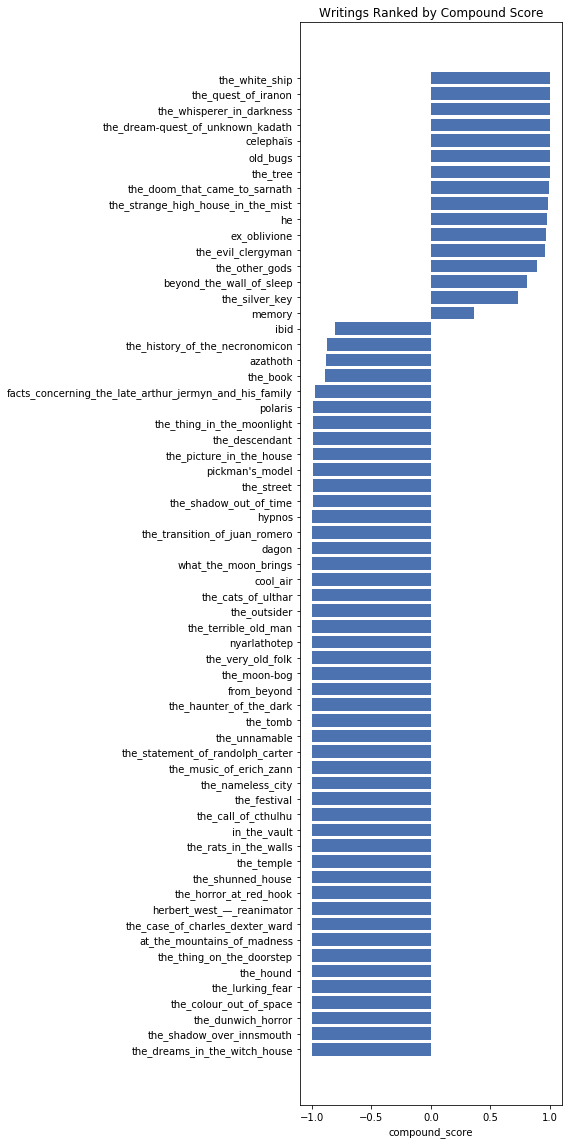

In [11]:
plt.figure(figsize = (8,16))
plt.barh(width = compound_score, y = titles)
plt.title('Writings Ranked by Compound Score')
plt.xlabel('compound_score')
plt.tight_layout()
plt.savefig('./results/sentiment_analysis_chart_compound_score.png')
plt.show()

In [12]:
neg_portion = np.array(neg_portion)
neu_portion = np.array(neu_portion)
pos_portion = np.array(pos_portion)

neg_plus_neu_portion = np.add(neg_portion, neu_portion)

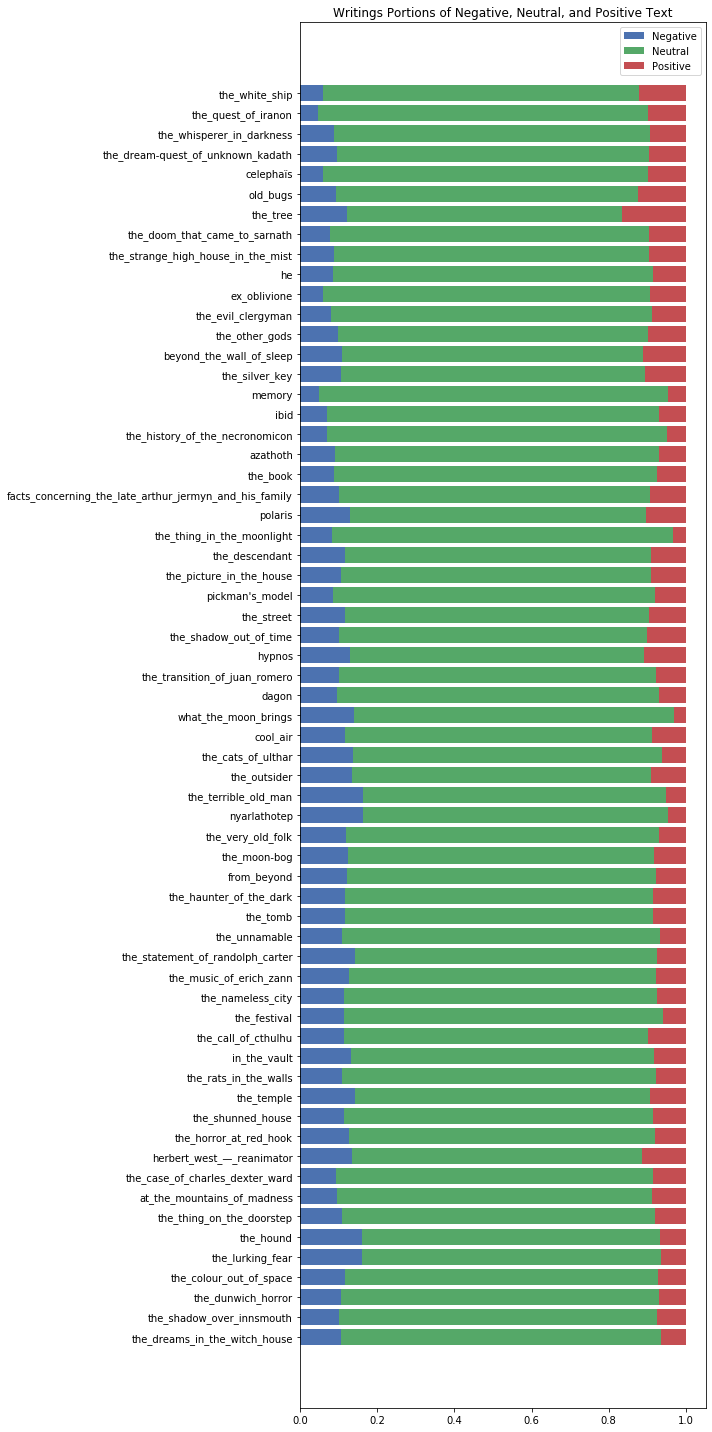

In [14]:
plt.figure(figsize = (10,20))
plt.barh(width = neg_portion, y = titles, label = 'Negative')
plt.barh(width = neu_portion, y = titles, label = 'Neutral', left = neg_portion)
plt.barh(width = pos_portion, y = titles, label = 'Positive', left = neg_plus_neu_portion)
plt.title('Writings Portions of Negative, Neutral, and Positive Text')
plt.legend()
plt.tight_layout()
plt.savefig('./results/sentiment_analysis_chart_text_portions.png')
plt.show()

# TF - IDF

## How it Works

First, we need a tokenizer function that takes a document and converts it into a list of text tokens. Using spaCy tokenizer with TfidfVectorizer from sklearn. 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [122]:
def spacy_tokenizer(document):
    tokens = nlp(document)
    tokens = [token for token in tokens if (
        token.is_stop == False and \
        token.is_punct == False and \
        token.lemma_.strip()!= '')]
    tokens = [token.lemma_ for token in tokens]
    return tokens

In [123]:
tfidf_vector = TfidfVectorizer(input = 'content', tokenizer = spacy_tokenizer)
corpus = [
    "Monsters are bad.", \
    "I saw a monster yesterday.", \
    "Why are we talking about bad monsters?"]
# fit: learns vocabulary and idf
# transform: transforms documents into document-term matrix
result = tfidf_vector.fit_transform(corpus)
result

<3x5 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [124]:
result.todense()

matrix([[0.78980693, 0.61335554, 0.        , 0.        , 0.        ],
        [0.        , 0.38537163, 0.65249088, 0.        , 0.65249088],
        [0.54783215, 0.42544054, 0.        , 0.72033345, 0.        ]])

In [125]:
tfidf_vector.get_feature_names()

['bad', 'monster', 'see', 'talk', 'yesterday']

In [126]:
dense = result.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, \
    columns=tfidf_vector.get_feature_names())
df

,bad,monster,see,talk,yesterday
0,0.789807,0.613356,0.000000,0.000000,0.000000
1,0.000000,0.385372,0.652491,0.000000,0.652491
2,0.547832,0.425441,0.000000,0.720333,0.000000


Could also play with max_df and min_df to limit frequency. 

Applying l2 normalization, so cosine similarity is the dot product. 

Trying to recreate first document TF-IDF. 
<br>

TF of both terms is 0.5. Because of l2-normalisation, we can drop this. 
IDF of bad: log(2+1/3+1), IDF of monster: log(3+1 / 3+1)

In [6]:
import math

In [11]:
math.log(4/3) + 1

1.2876820724517808

In [10]:
math.log(1) + 1

1.0

In [12]:
0.789807 / 0.613356

1.2876812161289692

In [13]:
1.2876820724517808 * 0.5

0.6438410362258904

In [14]:
(0.6438410362258904  **2 + 0.5**2) ** 0.5

0.8151878801407859

In [15]:
0.6438410362258904 / 0.8151878801407859

0.7898069290660905

In [16]:
0.5 / 0.8151878801407859

0.6133555370249717

In [127]:
# l2 normalisation check
(0.789807 **2 + 0.613356**2) ** 0.5

1.0000003399924422

From the point where we have the dense matrix, need to calculate cosine similarity by hand. 

https://intellipaat.com/community/1103/python-tf-idf-cosine-to-find-document-similarity

In [128]:
# linear kernel is same as a dot product
cosine_similarities = linear_kernel(result[0:1], result).flatten()
cosine_similarities

array([1.        , 0.23636982, 0.69362794])

In [129]:
0.613356 * 0.385372

0.236370228432

In [130]:
0.789807 * 0.547832 + 0.613356 * 0.425441

0.69362833842

Checking how we can convert cosine similarities in a df. 

In [131]:
cos_df = pd.DataFrame(columns=[0,1,2])

In [132]:
for i in range(2 + 1):
    curr_cos_sim = linear_kernel(result[i:i+1], result).flatten()
    cos_df[i] = curr_cos_sim

In [133]:
cos_df

,0,1,2
0,1.000000,0.236370,0.693628
1,0.236370,1.000000,0.163953
2,0.693628,0.163953,1.000000


## K-Means Cluster

This is interesting, I think we don't need to calculate the cosine similarities, because for normalised vectors, cosine distance is in a linear relationship with euclidean. 
https://stats.stackexchange.com/questions/299013/cosine-distance-as-similarity-measure-in-kmeans

In [138]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(result)

In [139]:
kmeans.labels_

array([0, 1, 0], dtype=int32)

OK, that's great, exactly what we wanted, sentences 0 and 2 are in the same group. 

## Using Filenames

If we pass on a list of filenames, it should work. 

In [114]:
filenames_test = [
    './data/original/txts_adjusted/at_the_mountains_of_madness.txt', 
    './data/original/txts_adjusted/azathoth.txt']

In [115]:
tfidf_vector = TfidfVectorizer(input = 'filename', tokenizer = spacy_tokenizer)

In [116]:
result = tfidf_vector.fit_transform(filenames_test)

In [117]:
result.todense()

matrix([[0.0070271 , 0.00351355, 0.00175677, ..., 0.0351355 , 0.0070271 ,
         0.00175677],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [120]:
tfidf_vector.get_feature_names()[-20:]

['wrong',
 'x.',
 'xi',
 'xii',
 'xiphodons',
 'yaanek',
 'yawn',
 'year',
 'yellowish',
 'yesterday',
 'yield',
 'yog',
 'young',
 'zeal',
 'zenith',
 'zero',
 'ziggurat',
 '°',
 '×',
 '–less']

## Putting it all Together

In [144]:
# define file paths
filepaths = []
for filename in filenames: 
    filepaths.append('./data/original/txts_adjusted/' + filename + '.txt')

In [145]:
tfidf_vector = TfidfVectorizer(input = 'filename', tokenizer = spacy_tokenizer)

In [146]:
# takes a long time
result = tfidf_vector.fit_transform(filepaths)

In [147]:
result

<63x17813 sparse matrix of type '<class 'numpy.float64'>'
	with 82441 stored elements in Compressed Sparse Row format>

In [148]:
# grouping them in two groups

In [164]:
kmeans_models = {}
for i in range(2,10+1):
    current_kmean = KMeans(n_clusters=i).fit(result)
    kmeans_models[i] = current_kmean

In [166]:
cluster_df = pd.DataFrame()
cluster_df['title'] = filenames
for i in range(2, 10+1):
    col_name = str(i) +'means_label'
    cluster_df[col_name] = kmeans_models[i].labels_

In [167]:
cluster_df

,title,2means_label,3means_label,4means_label,5means_label,6means_label,7means_label,8means_label,9means_label,10means_label
1,the_tomb,1,0,2,4,4,4,5,4,4
2,dagon,1,0,1,2,1,6,4,5,3
3,polaris,0,0,3,2,1,1,4,2,3
4,beyond_the_wall_of_sleep,1,0,1,4,2,5,1,5,4
5,memory,0,0,1,2,1,6,0,2,3
...,...,...,...,...,...,...,...,...,...,...
59,the_thing_on_the_doorstep,1,2,1,1,2,3,6,5,0
60,the_evil_clergyman,1,2,1,0,5,4,5,2,5
61,the_book,1,0,1,0,5,4,4,5,3
62,the_shadow_out_of_time,1,0,1,4,2,3,4,5,3


In [171]:
# dream titles
cluster_df[cluster_df['5means_label'] == 2]['title']

2                                  dagon
3                                polaris
5                                 memory
8                         the_white_ship
9          the_doom_that_came_to_sarnath
11                  the_terrible_old_man
12                              the_tree
14                            the_temple
16                            the_street
17                             celephaïs
19                          nyarlathotep
21                          ex_oblivione
22                     the_nameless_city
23                   the_quest_of_iranon
24                          the_moon-bog
30                  what_the_moon_brings
31                              azathoth
46    the_strange_high_house_in_the_mist
47     the_dream-quest_of_unknown_kadath
Name: title, dtype: object

In [183]:
cluster_df[cluster_df['10means_label'] == 8]['title']

20     the_picture_in_the_house
54           the_dunwich_horror
57    the_shadow_over_innsmouth
Name: title, dtype: object

In [184]:
cluster_df.to_csv('./results/word_counts/tfidf_clustering.csv', index = False)